In [21]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow.keras import backend as K
from tensorflow.keras import regularizers
from tensorflow.keras.layers import Input, Dense, Lambda
from tensorflow.keras.models import Model
from tensorflow.keras.datasets import mnist
from tensorflow.keras.losses import binary_crossentropy

# Autoencoder

In [2]:
encoding_dim = 32

input_img = Input(shape=(784,))
encoded = Dense(encoding_dim, activation="relu")(input_img)
decoded = Dense(784, activation="sigmoid")(encoded)

autoencoder = Model(input_img, decoded)

Metal device set to: Apple M2


2022-10-31 15:08:06.946964: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:306] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2022-10-31 15:08:06.947040: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:272] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


In [3]:
encoder = Model(input_img, encoded)

In [4]:
encoded_input = Input(shape=(encoding_dim,))
decoder_layer = autoencoder.layers[-1]
decoder = Model(encoded_input, decoder_layer(encoded_input))

In [5]:
autoencoder.compile(optimizer="adam", loss="binary_crossentropy")

In [30]:
(x_train, y_train), (x_test, y_test) = mnist.load_data()

In [31]:
x_train = x_train.astype("float32") / 255.0
x_test = x_test.astype("float32") / 255.0
x_train = x_train.reshape((len(x_train), np.prod(x_train.shape[1:])))
x_test = x_test.reshape((len(x_test), np.prod(x_test.shape[1:])))
print(x_train.shape)
print(x_test.shape)

(60000, 784)
(10000, 784)


In [8]:
autoencoder.fit(
    x_train,
    x_train,
    epochs=50,
    batch_size=256,
    shuffle=True,
    validation_data=(x_test, x_test),
    verbose=0,
)

2022-10-31 15:08:08.420943: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
2022-10-31 15:08:08.523255: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2022-10-31 15:08:09.534053: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


In [9]:
encoded_imgs = encoder.predict(x_test)
decoded_imgs = decoder.predict(encoded_imgs)

203/313 [==================>...........] - ETA: 0s

2022-10-31 15:08:54.276186: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


149/313 [=============>................] - ETA: 0s

2022-10-31 15:08:54.593482: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


313/313 [==============================] - 0s 719us/step


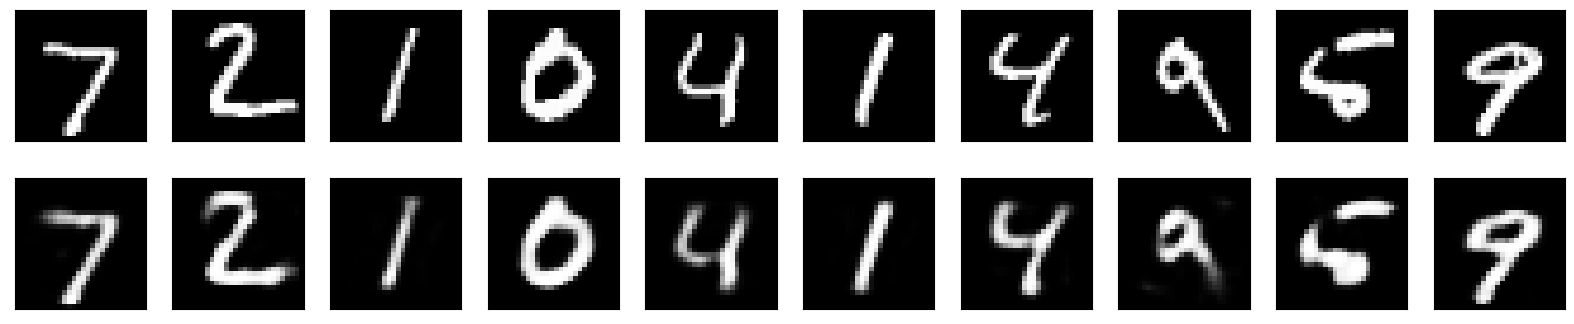

In [10]:
n = 10
plt.figure(figsize=(20, 4))
for i in range(n):
    # original
    ax = plt.subplot(2, n, i + 1)
    plt.imshow(x_test[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # reconstruction
    ax = plt.subplot(2, n, i + 1 + n)
    plt.imshow(decoded_imgs[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

In [11]:
input_img = Input(shape=(784,))
# use L1 regularization
encoded = Dense(
    encoding_dim,
    activation='relu',
    activity_regularizer=regularizers.l1(10e-5),
)(input_img)
decoded = Dense(784, activation='sigmoid')(encoded)

autoencoder = Model(input_img, decoded)

In [39]:
60000*784*8/2**30

0.3504753112792969

In [13]:
# train again, for longer
autoencoder.compile(optimizer="adam", loss="binary_crossentropy")

autoencoder.fit(
    x_train,
    x_train,
    epochs=100,
    batch_size=256,
    shuffle=True,
    validation_data=(x_test, x_test),
    verbose=0,
)

2022-10-31 15:09:38.952330: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2022-10-31 15:09:40.145538: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


In [14]:
encoded_imgs = encoder.predict(x_test)
decoded_imgs = decoder.predict(encoded_imgs)

313/313 [==============================] - 0s 664us/step


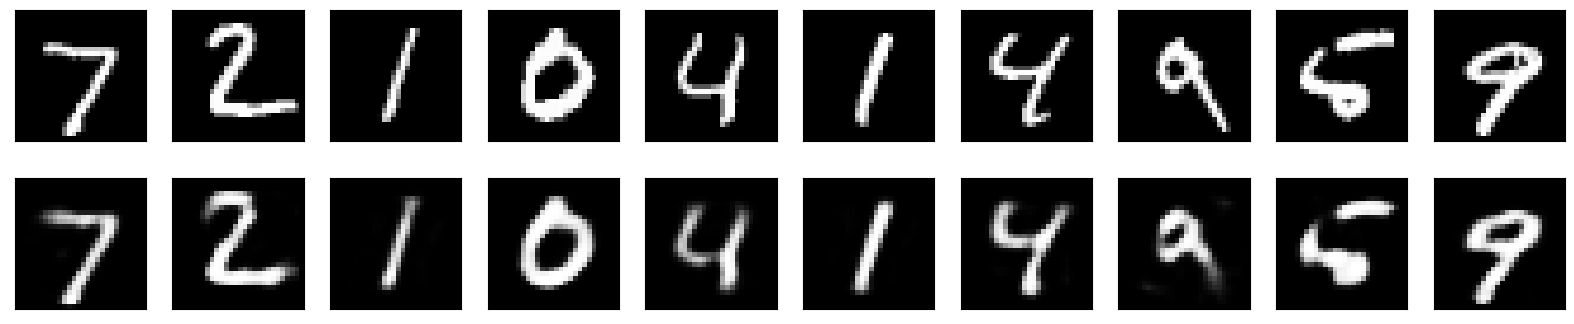

In [15]:
n = 10
plt.figure(figsize=(20, 4))
for i in range(n):
    # original
    ax = plt.subplot(2, n, i + 1)
    plt.imshow(x_test[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # reconstruction
    ax = plt.subplot(2, n, i + 1 + n)
    plt.imshow(decoded_imgs[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

# Variational Autoencoder

In [16]:
original_dim = 28 * 28
intermediate_dim = 64
latent_dim = 2

inputs = Input(shape=(original_dim,))
h = Dense(intermediate_dim, activation='relu')(inputs)
z_mean = Dense(latent_dim)(h)
z_log_sigma = Dense(latent_dim)(h)

In [19]:
def sampling(args):
    z_mean, z_log_sigma = args
    epsilon = K.random_normal(
        shape=(K.shape(z_mean)[0], latent_dim),
        mean=0.0,
        stddev=0.1,
    )
    return z_mean + K.exp(z_log_sigma) * epsilon

z = Lambda(sampling)([z_mean, z_log_sigma])

In [20]:
# encoder
encoder = Model(inputs, [z_mean, z_log_sigma, z], name='encoder')

# decoder
latent_inputs = Input(shape=(latent_dim,), name='z_sampling')
x = Dense(intermediate_dim, activation='relu')(latent_inputs)
outputs = Dense(original_dim, activation='sigmoid')(x)
decoder = Model(latent_inputs, outputs, name='decoder')

# VAE model
outputs = decoder(encoder(inputs)[2])
vae = Model(inputs, outputs, name='vae_mlp')

In [22]:
reconstruction_loss = binary_crossentropy(inputs, outputs)
reconstruction_loss *= original_dim
kl_loss = 1 + z_log_sigma - K.square(z_mean) - K.exp(z_log_sigma)
kl_loss = K.sum(kl_loss, axis=-1)
kl_loss *= -0.5
vae_loss = K.mean(reconstruction_loss + kl_loss)
vae.add_loss(vae_loss)
vae.compile(optimizer='adam')

In [23]:
# train on MNIST
vae.fit(
    x_train,
    x_train,
    epochs=100,
    batch_size=32,
    validation_data=(x_test, x_test),
)

Epoch 1/100


2022-10-31 15:16:55.322789: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


1867/1875 [============================>.] - ETA: 0s - loss: 186.7453

2022-10-31 15:17:06.500758: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


1875/1875 [==============================] - 12s 6ms/step - loss: 186.6479 - val_loss: 168.4271
Epoch 2/100
1875/1875 [==============================] - 10s 6ms/step - loss: 165.9079 - val_loss: 163.3656
Epoch 3/100
1875/1875 [==============================] - 10s 6ms/step - loss: 162.1619 - val_loss: 161.1638
Epoch 4/100
1875/1875 [==============================] - 10s 6ms/step - loss: 159.9178 - val_loss: 159.3336
Epoch 5/100
1875/1875 [==============================] - 10s 5ms/step - loss: 158.3170 - val_loss: 157.9389
Epoch 6/100
1875/1875 [==============================] - 10s 6ms/step - loss: 157.0660 - val_loss: 156.8313
Epoch 7/100
1875/1875 [==============================] - 10s 6ms/step - loss: 156.0811 - val_loss: 155.8229
Epoch 8/100
1875/1875 [==============================] - 10s 6ms/step - loss: 155.2059 - val_loss: 155.0922
Epoch 9/100
1875/1875 [==============================] - 10s 6ms/step - loss: 154.4999 - val_loss: 154.5611
Epoch 10/100
1875/1875 [================

1875/1875 [==============================] - 10s 6ms/step - loss: 144.4442 - val_loss: 146.8143
Epoch 77/100
1875/1875 [==============================] - 10s 6ms/step - loss: 144.4059 - val_loss: 146.5119
Epoch 78/100
1875/1875 [==============================] - 10s 6ms/step - loss: 144.3715 - val_loss: 146.7157
Epoch 79/100
1875/1875 [==============================] - 10s 6ms/step - loss: 144.3182 - val_loss: 146.5990
Epoch 80/100
1875/1875 [==============================] - 10s 5ms/step - loss: 144.3002 - val_loss: 146.5815
Epoch 81/100
1875/1875 [==============================] - 10s 6ms/step - loss: 144.2689 - val_loss: 146.5714
Epoch 82/100
1875/1875 [==============================] - 10s 6ms/step - loss: 144.2400 - val_loss: 146.3835
Epoch 83/100
1875/1875 [==============================] - 10s 6ms/step - loss: 144.1661 - val_loss: 146.8776
Epoch 84/100
1875/1875 [==============================] - 10s 6ms/step - loss: 144.1514 - val_loss: 146.5372
Epoch 85/100
1875/1875 [========

In [28]:
print(x_test_encoded[0].shape)

(10000, 2)


313/313 [==============================] - 0s 1ms/step


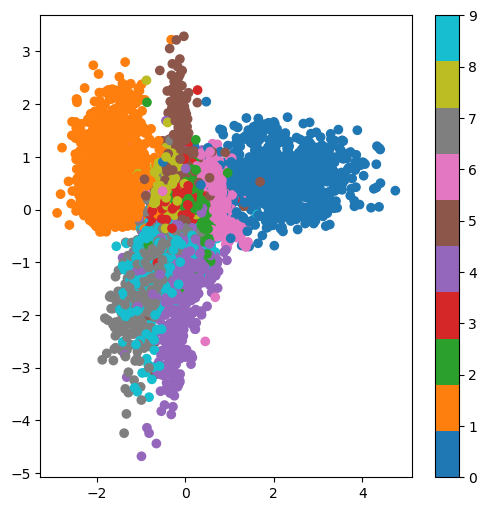

In [35]:
x_test_encoded = encoder.predict(x_test, batch_size=32)
plt.figure(figsize=(6, 6))
plt.scatter(x_test_encoded[0][:, 0], x_test_encoded[0][:, 1], c=y_test, cmap="tab10")
plt.colorbar()
plt.show()

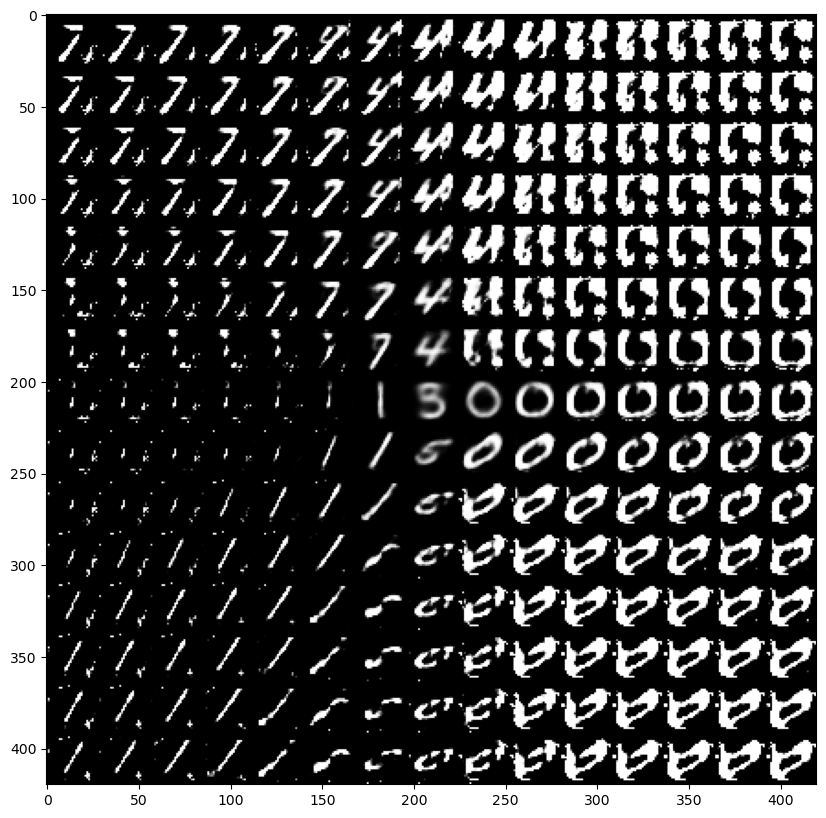

In [37]:
# Display a 2D manifold of the digits
n = 15  # figure with 15x15 digits
digit_size = 28
figure = np.zeros((digit_size * n, digit_size * n))
# We will sample n points within [-15, 15] standard deviations
grid_x = np.linspace(-15, 15, n)
grid_y = np.linspace(-15, 15, n)

for i, yi in enumerate(grid_x):
    for j, xi in enumerate(grid_y):
        z_sample = np.array([[xi, yi]])
        x_decoded = decoder.predict(z_sample, verbose=0)
        digit = x_decoded[0].reshape(digit_size, digit_size)
        figure[i * digit_size: (i + 1) * digit_size,
               j * digit_size: (j + 1) * digit_size] = digit

plt.figure(figsize=(10, 10))
plt.imshow(figure)
plt.show()